# Capstone Project - Retail Investor Behaviour Predictor in US Stock Market
### Machine Learning Engineer Nano-degree

Retail investor behaviour has always been an area of study in finance given their unique characteristics as well as their importance in the market place. According to regulatory disclosure from retail brokerage firms such as Charles Schwab, TD Ameritrade, etc., it is estimated that retail investor makes up about 15%-20% of volume in US equities market. Understanding how they behave is an interesting topic for any other market participants such as institutional investors and market makers. 

The problem of interest in this project is to find out if we can predict retail investor will buy or sell next day, given today’s information.  It is common for retail investors to make investment decisions based on readily observable information they can get easy access to, such as price, volume, and if peers surrounding them are also buying or selling. In this project, we will use these public information retail investors derive their decisions from, to find out if there exists a certain pattern of how they behave and predict it. 

## Data Pre-processing
In the first step, we read in all the raw data after aggregating from original data source. Please see merge_price_files.py and merge_popularity_files.py for details of merging process. 

The aggregated Robinhood popularity file will be merged with the aggregated end-of-day prices file based on ticker per date.

We will check the most basics of the data, such as number of symbols covered, date range, number of NAs, etc.

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
# S3 bucket name
bucket_name = 'sagemaker-us-east-1-420440669876'

In [4]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::420440669876:role/service-role/AmazonSageMaker-ExecutionRole-20190923T210467


In [5]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['all_holdings.csv', 'all_holdings_sp500.csv', 'all_prices.csv', 'all_prices_sp500.csv']


In [6]:
# get an S3 object by passing in the bucket and file name
data_object_holdings = s3_client.get_object(Bucket=bucket_name, Key='all_holdings.csv')
data_object_prices = s3_client.get_object(Bucket=bucket_name, Key='all_prices.csv')

# what info does the object contain?
display(data_object_holdings)
display(data_object_prices)

{'ResponseMetadata': {'RequestId': '0D0B708EC282DA8E',
  'HostId': 'qXCENgO3CYbf7weGqX3a9pr3CwVlLL2D9mYkEsfn91soCyaGgv3ytPrvrwQqz1eq+fKqdnVyMKA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'qXCENgO3CYbf7weGqX3a9pr3CwVlLL2D9mYkEsfn91soCyaGgv3ytPrvrwQqz1eq+fKqdnVyMKA=',
   'x-amz-request-id': '0D0B708EC282DA8E',
   'date': 'Tue, 26 Nov 2019 05:15:12 GMT',
   'last-modified': 'Wed, 06 Nov 2019 05:26:40 GMT',
   'etag': '"1313b7b7b139bdce00ba0c7b59c2fad6-4"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '54217223',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2019, 11, 6, 5, 26, 40, tzinfo=tzutc()),
 'ContentLength': 54217223,
 'ETag': '"1313b7b7b139bdce00ba0c7b59c2fad6-4"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f5e0e8d7588>}

{'ResponseMetadata': {'RequestId': '075B45B936CC5D46',
  'HostId': 'tHhBxEjUWnYuT/iFzKUPB3X0qc+L08BZ606Lb9t87+KNfwRBi/G8lsBKJz5fL9EmqHIgRXt/77w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'tHhBxEjUWnYuT/iFzKUPB3X0qc+L08BZ606Lb9t87+KNfwRBi/G8lsBKJz5fL9EmqHIgRXt/77w=',
   'x-amz-request-id': '075B45B936CC5D46',
   'date': 'Tue, 26 Nov 2019 05:15:12 GMT',
   'last-modified': 'Wed, 06 Nov 2019 05:26:40 GMT',
   'etag': '"eb622d74bc2b018108ab1735002fbb4f-26"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '437731919',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2019, 11, 6, 5, 26, 40, tzinfo=tzutc()),
 'ContentLength': 437731919,
 'ETag': '"eb622d74bc2b018108ab1735002fbb4f-26"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f5e0e8d7a58>}

In [7]:
# read in bytes data
data_body_holdings = data_object_holdings["Body"].read()
data_stream_holdings = io.BytesIO(data_body_holdings)

data_body_prices = data_object_prices["Body"].read()
data_stream_prices = io.BytesIO(data_body_prices)

In [8]:
holdings = pd.read_csv(data_stream_holdings, header=0, sep=',')
print(holdings.head())

prices = pd.read_csv(data_stream_prices, header=0, sep=',')
print(prices.head())

  symbol        date  first_hld  last_hld  std_hld
0   CSCO  2018-05-02      23646     23646   0.0000
1   CSCO  2018-05-03      23765     23718  21.7609
2   CSCO  2018-05-04      23718     23553  82.2720
3   CSCO  2018-05-05      23553     23552   0.4714
4   CSCO  2018-05-06      23552     23552   0.0000
  symbol        date     open     high      low    close  volume
0    RIV  2015-12-24  13.2175  13.2441  13.1843  13.1843  436450
1    RIV  2015-12-28  13.2043  13.2498  13.1511  13.1511   97077
2    RIV  2015-12-29  13.1245  13.2109  13.1179  13.1910   17490
3    RIV  2015-12-30  13.2043  13.2441  13.1710  13.2441    8458
4    RIV  2015-12-31  13.2441  13.2441  13.1843  13.2175    4103


In [9]:
merged = holdings.merge(prices, on=['symbol', 'date'], how='inner')

In [10]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876223 entries, 0 to 876222
Data columns (total 10 columns):
symbol       876223 non-null object
date         876223 non-null object
first_hld    876223 non-null int64
last_hld     876223 non-null int64
std_hld      876223 non-null float64
open         875688 non-null float64
high         875688 non-null float64
low          875688 non-null float64
close        876223 non-null float64
volume       876223 non-null int64
dtypes: float64(5), int64(3), object(2)
memory usage: 73.5+ MB


In [11]:
# Check date range from the raw files across all stocks.
print(merged['date'].max(), merged['date'].min())
print(holdings['date'].max(), holdings['date'].min())
print(prices['date'].max(), prices['date'].min())

2019-06-11 2018-05-02
2019-10-17 2018-05-02
2019-06-11 2014-06-23


In [12]:
# Check number of unique stocks in each file. 
# Since only stocks that exist in price files were included when I aggregated Robinhood popularity file, the numbers are about the same. 
print(merged['symbol'].nunique())
print(holdings['symbol'].nunique())
print(prices['symbol'].nunique())

3235
3235
8516


In [13]:
# Transform date from string to datetime, and make symbol and date as multiindex of the dataframe. 
# Sort by symbol and date. Sorting by date is extremely important given we will use index to split training and test data later. 
merged['date'] = pd.to_datetime(merged['date'])
merged.set_index(['symbol','date'], inplace=True)
merged.sort_index(ascending=True, inplace=True)
print(merged.iloc[:5,:])
print(merged.iloc[-5:,:])

                   first_hld  last_hld  std_hld     open     high      low  \
symbol date                                                                  
A      2018-05-02        590       590   0.0000  65.4062  66.2584  65.1782   
       2018-05-03        586       587   0.4993  65.1782  65.8620  64.2764   
       2018-05-04        587       588   0.4983  65.4359  66.6449  64.9503   
       2018-05-07        588       576   3.9737  66.5557  67.3683  66.4665   
       2018-05-08        576       580   1.5894  66.4764  66.8282  66.2386   

                     close   volume  
symbol date                          
A      2018-05-02  65.3170  2240482  
       2018-05-03  65.7431  2365851  
       2018-05-04  66.3972  1331017  
       2018-05-07  66.7837  1468735  
       2018-05-08  66.7638  1916103  
                   first_hld  last_hld  std_hld   open     high    low  close  \
symbol date                                                                     
ZYNE   2019-06-05      23

In [14]:
merged.loc[merged['open'].isnull(), ['open', 'high', 'low']] = merged['close']

In [15]:
# Check number of NA in each column in the dataframe. 
print(merged.isnull().sum())
merged.dropna(inplace=True)

first_hld    0
last_hld     0
std_hld      0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


## KMeans - split stocks to different groups

In [16]:
# group data by stock and take average value of each column across time series
stock_mean = merged.groupby(level=0).agg('mean')
kmeans_train_features = stock_mean.values

# standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
kmeans_train_features = scaler.fit_transform(kmeans_train_features)

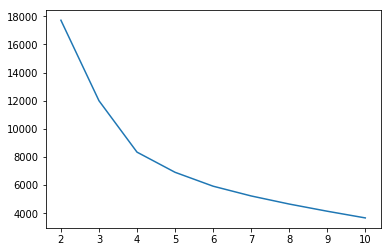

In [17]:
from sklearn.cluster import KMeans
K_arr = np.empty((0, 1))
distance_arr = np.empty((0,1))

# try clustering with number of clusters value from 2 to 10
for K in range(10,1,-1):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(kmeans_train_features)
    sum_distance = kmeans.inertia_
    K_arr = np.append(K_arr, K)
    distance_arr = np.append(distance_arr, sum_distance)

plt.plot(K_arr, distance_arr)
plt.show()

In [18]:
# decide the best number of cluster use from the elbow shaped chart above
best_K = 4
kmeans = KMeans(n_clusters=best_K, random_state=0).fit(kmeans_train_features)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [19]:
stock_cluster = pd.DataFrame(np.concatenate((kmeans_train_features, labels[:, np.newaxis]), axis=1), columns=merged.columns.to_list() + ['cluster'], index=stock_mean.index.get_level_values('symbol'))

In [20]:
centroids_cluster = pd.DataFrame(centroids, columns=merged.columns.to_list())

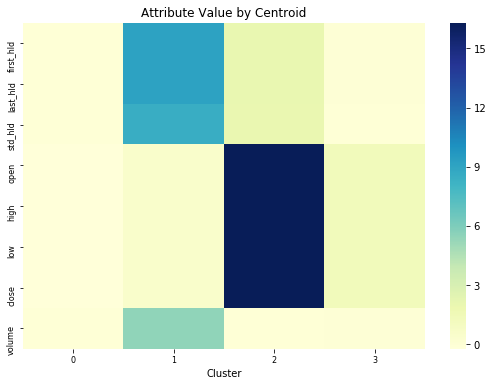

In [21]:
# generate a heatmap to show features of centroids of clusters
plt.figure(figsize = (9,6))
ax = sns.heatmap(centroids_cluster.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [22]:
cluster = 1
stock_list_cluster = stock_cluster.loc[stock_cluster['cluster'] == cluster, ].index.to_list()
merged_cluster = merged.loc[merged.index.get_level_values('symbol').isin(stock_list_cluster), ]
len(merged_cluster.index.get_level_values('symbol').unique())

27

In [23]:
merged_cluster.index.get_level_values('symbol').unique()

Index(['AAPL', 'AMD', 'APHA', 'BABA', 'BAC', 'CGC', 'CHK', 'CRON', 'DIS', 'F',
       'FB', 'FIT', 'GE', 'GPRO', 'MSFT', 'MU', 'NFLX', 'NIO', 'NVDA', 'PLUG',
       'SNAP', 'SPY', 'SQ', 'T', 'TSLA', 'TWTR', 'ZNGA'],
      dtype='object', name='symbol')

In [24]:
merged = merged_cluster

## Data Exploration and Visualization

In this section, we will transform absolute values into percentage change from previous day. This gives us the benefit of normalizing the data as a starting point, both accross different stocks and along time horizon for the same stock over time. 

We will examine distribution of these percentage changes by looking at their percentiles and via visulizing them through histograms as well as checking the number of outliers. 

In addition to checking features, we will also take a closer look at the column we intend to use as the target - Robinhood user holding percentage change. We will look at how balanced the data is and the data quality. 


In [25]:
# Calculate percentage change from previous day for close price, volume, Robinhood user holding.
# Since close price and volume data are snapped at end of the day, we use the last timestamp of Robinhood user holding to make it consistent. 
for idx, data in merged.groupby(level=0):
    merged.loc[idx, 'close_pct_chg_1d'] = data['close'].pct_change(periods=1)
    merged.loc[idx, 'volume_pct_chg_1d'] = data['volume'].pct_change(periods=1)
    merged.loc[idx, 'hld_pct_chg_1d'] = data['last_hld'].pct_change(periods=1)

In [26]:
merged.head()

first_hld  last_hld    std_hld      open      high  \
symbol date                                                             
AAPL   2018-05-02     150785    150785     0.0000  171.9347  174.4123   
       2018-05-03     145510    143747   750.6533  172.5774  174.1670   
       2018-05-04     143747    141424  1148.8285  174.9029  180.7902   
       2018-05-07     141437    141179   114.3427  181.7028  184.1460   
       2018-05-08     141179    140820   142.4915  181.5163  182.7232   

                        low     close    volume  close_pct_chg_1d  \
symbol date                                                         
AAPL   2018-05-02  170.5365  173.2544  66539371               NaN   
       2018-05-03  171.1655  173.5684  34068180          0.001812   
       2018-05-04  174.8244  180.3781  56201317          0.039234   
       2018-05-07  181.2808  181.6831  42451423          0.007235   
       2018-05-08  180.2162  182.5564  28402777          0.004807   

                   volume_pct_chg_1d  hld_pct_chg_1d  
symbol date                                           
AAPL   2018-05-02                NaN             NaN  
       2018-05-03          -0.488000       -0.046676  
       2018-05-04           0.649672       -0.016160  
       2018-05-07          -0.244654       -0.001732  
       2018-05-08          -0.330935       -0.002543

In [27]:
# Calculate percentage change from the day's open to close, low to high to normalize data
merged['close_open_1d'] = merged['close'] / merged['open'] - 1
merged['high_low_1d'] = merged['high'] / merged['low'] - 1

# Calculate percentage change from the day's first Robinhood holding reading to last reading
merged['intraday_hld_chg_1d'] = merged['last_hld'] / merged['first_hld'] - 1

# Rename std_hld column to std_hld_1d to be consistent with others
merged.rename(columns={'std_hld':'std_hld_1d'}, inplace=True)

In [28]:
# Check statistics metrics of all the columns
merged.describe()

,first_hld,last_hld,std_hld_1d,open,high,low,close,volume,close_pct_chg_1d,volume_pct_chg_1d,hld_pct_chg_1d,close_open_1d,high_low_1d,intraday_hld_chg_1d
count,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7.139000e+03,7112.000000,7112.000000,7112.000000,7139.000000,7139.000000,7139.000000
mean,106745.110099,106977.947051,198.436256,84.076324,85.256470,82.837926,84.075695,2.860958e+07,0.000854,0.090049,0.004309,-0.000147,0.038609,0.004667
std,53283.343668,53316.058791,392.277328,102.355128,103.723617,100.894399,102.354226,3.212527e+07,0.034263,0.588058,0.051423,0.029532,0.032050,0.070196
min,149.000000,768.000000,0.000000,1.020000,1.050000,0.989200,1.010000,6.152470e+05,-0.284144,-0.790259,-0.067657,-0.245658,0.002699,-0.067648
25%,67244.000000,67320.500000,46.307200,7.728650,7.955000,7.500000,7.705000,8.103086e+06,-0.013338,-0.217115,-0.001058,-0.012178,0.019629,-0.001027
50%,99854.000000,99948.000000,103.293800,30.496600,30.795600,30.202300,30.535800,1.821427e+07,0.000586,-0.023943,0.001058,0.000000,0.030890,0.000998
75%,143802.000000,143980.500000,223.338900,145.701850,148.915000,143.220000,146.010000,3.735176e+07,0.013863,0.234652,0.004269,0.011651,0.048056,0.004157
max,269313.000000,269313.000000,18182.902300,421.380000,423.205600,413.080000,418.970000,3.486395e+08,0.757576,19.281615,3.369951,0.752266,0.946319,4.154362


In [29]:
# Check abnormal volume changes and delete outliers. 
# Most of them are due to inactive trading or corporate actions, which we don't want to corrupt our time series. 

volume_chg = merged.groupby(level=0)['volume_pct_chg_1d'].agg(['min', 'max', 'mean'])
volume_chg_extreme = volume_chg.loc[(volume_chg['mean'] > 1) | (volume_chg['max'] > 10), ]
print("Number of stocks with extreme volume changes :", len(volume_chg_extreme.index))
stock_with_volume_chg_extreme = volume_chg_extreme.index.to_list()

Number of stocks with extreme volume changes : 1


In [30]:
merged_clean = merged.loc[~merged.index.get_level_values('symbol').isin(stock_with_volume_chg_extreme), ]

In [31]:
diff = len(merged.index.get_level_values('symbol').unique()) - len(merged_clean.index.get_level_values('symbol').unique())
print("Confirmed ", diff, " stocks were deleted")

Confirmed  1  stocks were deleted


In [32]:
merged_clean.describe()

,first_hld,last_hld,std_hld_1d,open,high,low,close,volume,close_pct_chg_1d,volume_pct_chg_1d,hld_pct_chg_1d,close_open_1d,high_low_1d,intraday_hld_chg_1d
count,6993.000000,6993.000000,6993.000000,6993.000000,6993.000000,6993.000000,6993.000000,6.993000e+03,6967.000000,6967.000000,6967.000000,6993.000000,6993.000000,6993.000000
mean,108146.157729,108374.491777,198.450793,85.659585,86.859013,84.401541,85.659323,2.906919e+07,0.000899,0.086468,0.003596,-0.000153,0.037856,0.003375
std,52840.428886,52881.069500,394.493535,102.823490,104.199674,101.353866,102.822304,3.228710e+07,0.033387,0.537956,0.045334,0.028554,0.030862,0.043892
min,875.000000,881.000000,0.000000,1.020000,1.050000,0.989200,1.010000,6.569000e+05,-0.284144,-0.790259,-0.067657,-0.245658,0.002699,-0.067648
25%,69555.000000,69684.000000,46.075100,8.060000,8.306700,7.750000,8.060000,8.421188e+06,-0.012984,-0.215993,-0.001086,-0.011994,0.019476,-0.001068
50%,100803.000000,100883.000000,103.239000,30.860000,31.320300,30.528500,30.895700,1.868519e+07,0.000651,-0.023485,0.000993,0.000000,0.030457,0.000938
75%,144599.000000,144673.000000,222.838000,149.200000,151.470800,146.470000,148.966200,3.789275e+07,0.013759,0.232872,0.004085,0.011536,0.047266,0.003965
max,269313.000000,269313.000000,18182.902300,421.380000,423.205600,413.080000,418.970000,3.486395e+08,0.757576,8.446059,3.369951,0.752266,0.946319,3.369951


In [33]:
# Check percentage changes > 20% or < -20%
(merged_clean[['hld_pct_chg_1d', 'close_pct_chg_1d', 'volume_pct_chg_1d']].abs() > 0.2).sum() / len(merged_clean.index)

hld_pct_chg_1d       0.001001
close_pct_chg_1d     0.002002
volume_pct_chg_1d    0.541542
dtype: float64

In [34]:
# Check percentage changes > 100% or < -100%
(merged_clean[['hld_pct_chg_1d', 'close_pct_chg_1d', 'volume_pct_chg_1d']].abs() > 1).sum() / len(merged_clean.index)

hld_pct_chg_1d       0.000143
close_pct_chg_1d     0.000000
volume_pct_chg_1d    0.044616
dtype: float64

In [35]:
# Drop all the absoluate columns  
merged_clean = merged_clean.drop(columns=['first_hld','last_hld','open','high','low','close','volume'])

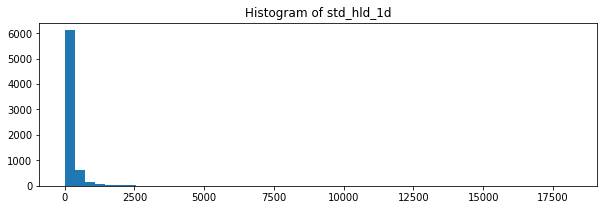

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


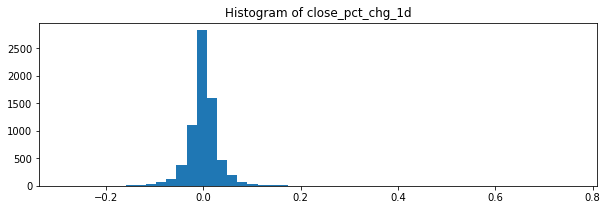

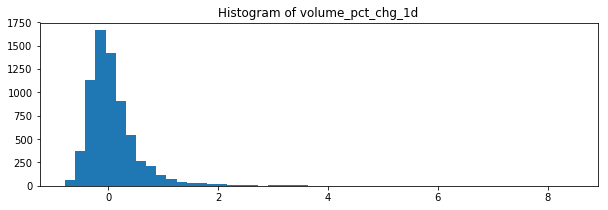

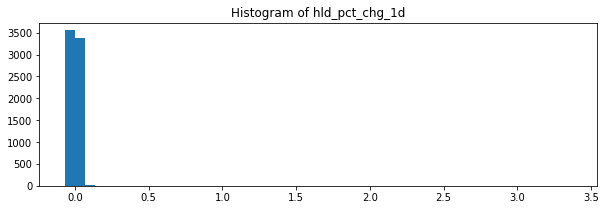

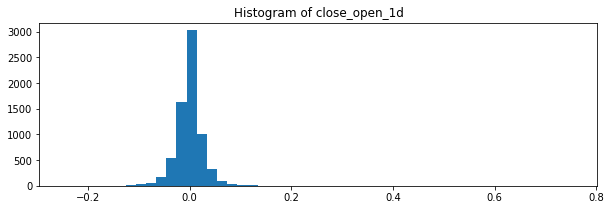

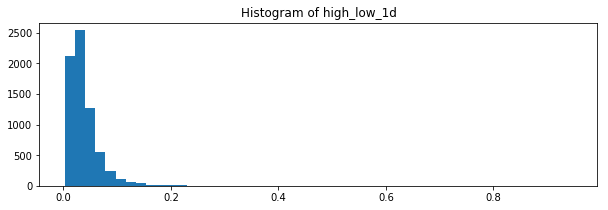

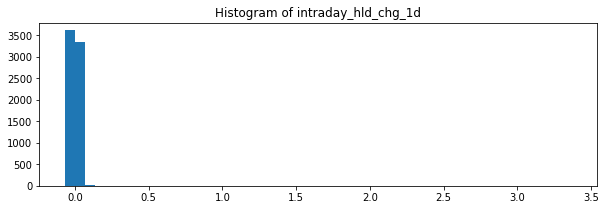

In [36]:
# Visualize distribution of all the columns data

cols = merged_clean.columns.to_list()
n_bins = 50 # can decrease to get a wider bin (or vice versa)

for col in cols:
    ax=plt.subplots(figsize=(10,3))
    # get data by column_name and display a histogram
    ax = plt.hist(merged_clean[col], bins=n_bins)
    title="Histogram of " + col
    plt.title(title, fontsize=12)
    plt.show()

In [37]:
# Check if target data is balanced by looking at number of cases where Robinhood user holding remains flat, increased or decreased
print((merged_clean['hld_pct_chg_1d'] == 0).sum() / (merged_clean['hld_pct_chg_1d'].count()))
print((merged_clean['hld_pct_chg_1d'] > 0).sum() / (merged_clean['hld_pct_chg_1d'].count()))
print((merged_clean['hld_pct_chg_1d'] < 0).sum() / (merged_clean['hld_pct_chg_1d'].count()))

0.00516721687957514
0.6164776804937563
0.3783551026266686


In [38]:
# Check further among cases where Robinhood user holding remains flat, if it happens across a wide range of stocks and dates or concentraded in a few stocks and dates
# If it sparsely occurred across names and dates, it is less concerning since it is unlikely some single stocks suffer from poor data quality
hld_no_change = merged_clean.loc[merged['hld_pct_chg_1d'] == 0,]
hld_no_change.reset_index(inplace=True)
print(hld_no_change['symbol'].nunique())
print(hld_no_change['date'].nunique())

23
13


## Data Modeling

Now we have normalized the original data all into percentage values, and arrived at 3 intraday columns and 3 day-to-day change columns:

4 intraday columns:

    std_hld_1d: standard deviation of user holdings data across all the timestamps on the day
    
    close_open_1d: percentage change from the day's open price to close price
    
    high_low_1d: percentage change from the day's highest price to lowest price (always >= 0)
    
    intraday_hld_pct_chg_1d: percentage change from the day's first Robinhood holding reading to last reading

3 day-to-day columns:

    close_pct_chg_1d: percentage change from previous trading day's close price to today's 
    
    volume_pct_chg_1d: percentage change from previous trading day's volume to today's
    
    hld_pct_chg_1d: percentage change from previous trading day's Robinhood user holding to today's 
    
### Autocorrelation
We want to first check the autocorrelation among features. We will choose 10 stocks randomly and glimpse into the autocorrelation pattern on them to have a reasonable estimate on how many days back of data we should include to derive an estimate for next day. 

In [39]:
symbol_list = merged_clean.index.get_level_values(level='symbol').unique().to_list()
random_int = np.random.randint(0, len(symbol_list), size=1)
symbol_sample = []
for i in random_int:
    symbol_sample.append(symbol_list[i])
print(symbol_sample)

['FIT']


In [40]:
merged_clean.dropna(inplace=True)

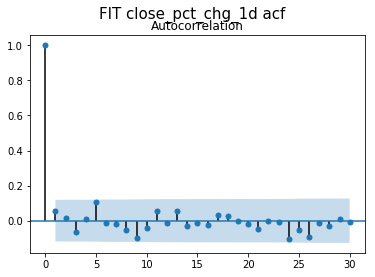

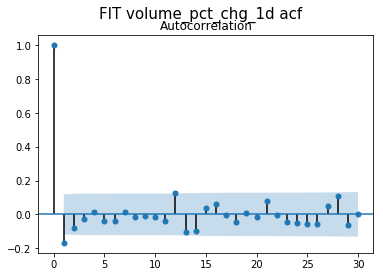

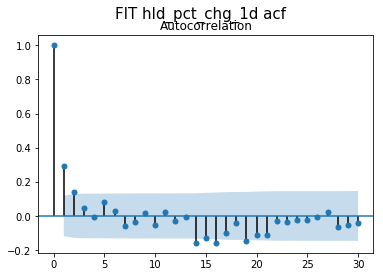

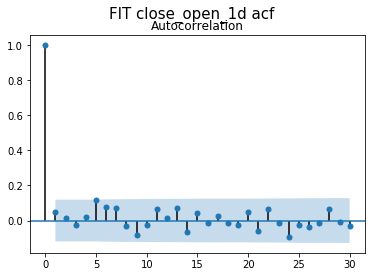

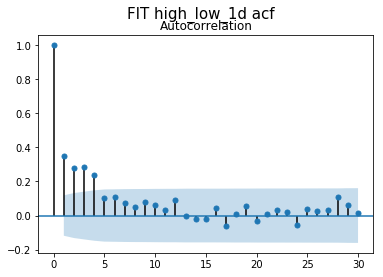

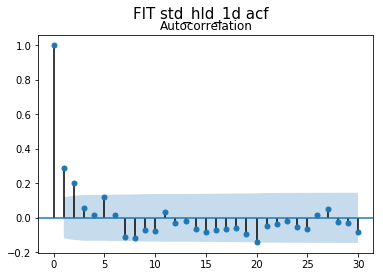

In [41]:
# calculate acf for random 10 names
from statsmodels.graphics.tsaplots import plot_acf

for symbol in symbol_sample:
    
    close_acf = plot_acf(merged_clean.loc[symbol, 'close_pct_chg_1d'], lags = 30)
    close_acf.suptitle(symbol + ' close_pct_chg_1d acf', fontsize=15)

    volume_acf = plot_acf(merged_clean.loc[symbol, 'volume_pct_chg_1d'], lags = 30)
    volume_acf.suptitle(symbol + ' volume_pct_chg_1d acf', fontsize=15)

    hld_acf = plot_acf(merged_clean.loc[symbol, 'hld_pct_chg_1d'], lags = 30)
    hld_acf.suptitle(symbol + ' hld_pct_chg_1d acf', fontsize=15)
    
    close_open_acf = plot_acf(merged_clean.loc[symbol, 'close_open_1d'], lags = 30)
    close_open_acf.suptitle(symbol + ' close_open_1d acf', fontsize=15)

    high_low_acf = plot_acf(merged_clean.loc[symbol, 'high_low_1d'], lags = 30)
    high_low_acf.suptitle(symbol + ' high_low_1d acf', fontsize=15)

    std_hld_acf = plot_acf(merged_clean.loc[symbol, 'std_hld_1d'], lags = 30)
    std_hld_acf.suptitle(symbol + ' std_hld_1d acf', fontsize=15)


### Correlation
Check correlation across figures, and highlight pairs with high correlation (>0.8)

In [42]:
corr_matrix = merged_clean.corr().abs().round(2)

In [43]:
corr_matrix

,std_hld_1d,close_pct_chg_1d,volume_pct_chg_1d,hld_pct_chg_1d,close_open_1d,high_low_1d,intraday_hld_chg_1d
std_hld_1d,1.00,0.10,0.21,0.41,0.11,0.36,0.43
close_pct_chg_1d,0.10,1.00,0.14,0.23,0.82,0.09,0.24
volume_pct_chg_1d,0.21,0.14,1.00,0.06,0.06,0.31,0.06
hld_pct_chg_1d,0.41,0.23,0.06,1.00,0.26,0.38,0.97
close_open_1d,0.11,0.82,0.06,0.26,1.00,0.07,0.27
high_low_1d,0.36,0.09,0.31,0.38,0.07,1.00,0.39
intraday_hld_chg_1d,0.43,0.24,0.06,0.97,0.27,0.39,1.00


In [44]:
# Print the pair of features with correlation higher than 0.8
corr = corr_matrix.to_numpy()
col = corr_matrix.columns.to_list()
row = corr_matrix.index.to_list()
for i in range(0, len(row)):
    for j in range(0, len(col)):
        if (corr[i, j] > 0.8) & (i < j):
            print(row[i], col[j])

close_pct_chg_1d close_open_1d
hld_pct_chg_1d intraday_hld_chg_1d


### Create data shift
After examining correlation and autocorrelation, it is time to create data shift. For each date, we provide percentage change numbers from T-5 to T-1 of all the features, by shifting those percentage change data per stock upwards. 

To get target column 'y', we shift holding percentage change data backwards for one day, to become last trading day's target. 

In [45]:
cols = merged_clean.columns.to_list()
cols_num = len(cols)

for idx, data in merged_clean.groupby(level=0):
    for i in range(5, 1, -1):
        for col in cols:
            new_col = col.replace('1', str(i))
            merged_clean.loc[idx, new_col] = data[col].shift(i-1)
    merged_clean.loc[idx, 'y'] = data['hld_pct_chg_1d'].shift(-1)    

In [46]:
# Change order of columns to "features of T-5 .... T-1, Target" for easier later implementation in LSTM model
cols = merged_clean.columns.to_list()
cols = cols[cols_num:-1] + cols[0:cols_num] + [cols[-1]]
merged_clean = merged_clean[cols]

In [47]:
# Drop NA columns again since shifting data to get T-5 created up to 5 rows of NA rows at the beginning of each stock's data
merged_clean.dropna(inplace=True)

In [48]:
merged_clean.loc[merged_clean['y'] > 0, 'y_code'] = 0
merged_clean.loc[merged_clean['y'] == 0, 'y_code'] = 1 
merged_clean.loc[merged_clean['y'] < 0, 'y_code'] = 2 
merged_clean['y_code'] = merged_clean['y_code'].astype('int')
merged_clean = merged_clean.drop(columns=['y'])

In [49]:
merged_clean.columns.values

array(['std_hld_5d', 'close_pct_chg_5d', 'volume_pct_chg_5d',
       'hld_pct_chg_5d', 'close_open_5d', 'high_low_5d',
       'intraday_hld_chg_5d', 'std_hld_4d', 'close_pct_chg_4d',
       'volume_pct_chg_4d', 'hld_pct_chg_4d', 'close_open_4d',
       'high_low_4d', 'intraday_hld_chg_4d', 'std_hld_3d',
       'close_pct_chg_3d', 'volume_pct_chg_3d', 'hld_pct_chg_3d',
       'close_open_3d', 'high_low_3d', 'intraday_hld_chg_3d',
       'std_hld_2d', 'close_pct_chg_2d', 'volume_pct_chg_2d',
       'hld_pct_chg_2d', 'close_open_2d', 'high_low_2d',
       'intraday_hld_chg_2d', 'std_hld_1d', 'close_pct_chg_1d',
       'volume_pct_chg_1d', 'hld_pct_chg_1d', 'close_open_1d',
       'high_low_1d', 'intraday_hld_chg_1d', 'y_code'], dtype=object)

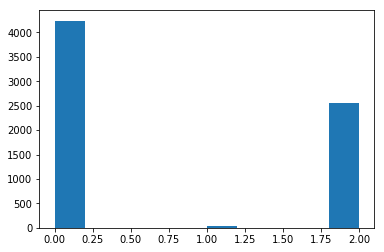

In [50]:
plt.hist(merged_clean['y_code'])
plt.show()

## Train Test Data Split

One unique thing about the data here is they are arranged in symbol / date multiindex. To split train test data for this time-series problem across stocks, it is only fair to use earlier dates as training data, and later dates as test data, to avoid look ahead bias. Furthermore, because we look across stocks, we will need to loop over all the stocks and create the train-test split by date per stock.

In [51]:
# split into train/test
from keras.utils.np_utils import to_categorical

def train_test_split(df, train_frac= 0.7):
    
    train_features = np.empty((0,len(df.columns)-1))
    train_labels = np.empty((0,3))
    train_labels_original = np.empty((0,))
    test_features = np.empty((0,len(df.columns)-1))
    test_labels = np.empty((0,3))
    test_labels_original = np.empty((0,))
    
    for idx, data in df.groupby(level=0):
        # convert the df into a matrix for ease of splitting
        data_matrix = data.values
        # split the data
        train_size = int(data_matrix.shape[0] * train_frac)
        
        # features are all but last column
        train_features_clip  = data_matrix[:train_size, :-1]
        test_features_clip = data_matrix[train_size:, :-1]
        # class labels are last column
        train_labels_clip_original = data_matrix[:train_size, -1]
        train_labels_clip = to_categorical(train_labels_clip_original, num_classes=3)
        test_labels_clip_original = data_matrix[train_size:, -1]
        test_labels_clip = to_categorical(test_labels_clip_original, num_classes=3)
        
        # aggregate train and test data across symbols 
        train_features = np.append(train_features, train_features_clip, axis=0)
        train_labels = np.append(train_labels, train_labels_clip, axis=0)
        train_labels_original = np.append(train_labels_original, train_labels_clip_original, axis=0) 
        test_features = np.append(test_features, test_features_clip, axis=0)
        test_labels = np.append(test_labels, test_labels_clip, axis=0)
        test_labels_original = np.append(test_labels_original, test_labels_clip_original, axis=0) 
        
    plt.hist(train_labels_original)
    plt.title('train_labels')
    plt.show()
        
    plt.hist(test_labels_original)
    plt.title('test_labels')
    plt.show()
    
    return (train_features, train_labels, train_labels_original), (test_features, test_labels, test_labels_original)

Using TensorFlow backend.


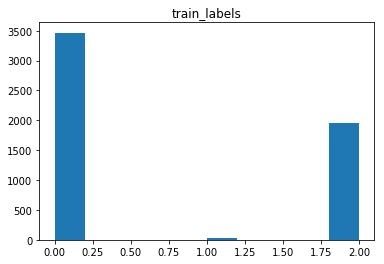

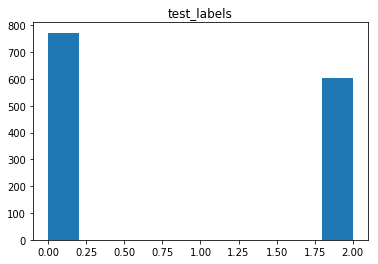

In [52]:
# get train/test data
(train_features, train_labels, train_labels_original), (test_features, test_labels, test_labels_original) = train_test_split(merged_clean, train_frac=0.8)



In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

## PCA

In [54]:
from sklearn.decomposition import PCA
n_components = 20
pca = PCA(n_components=n_components)
pca.fit(train_features)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [55]:
print(pca.explained_variance_ratio_)  

[0.17998454 0.09209963 0.07483564 0.06188487 0.05997429 0.05336854
 0.04952368 0.04339164 0.04105949 0.04013256 0.03767256 0.03645032
 0.03163475 0.02953983 0.02657263 0.02494667 0.01618988 0.01397628
 0.01026704 0.00821368]


In [56]:
print(pca.singular_values_)  

[185.44202853 132.65374452 119.57622049 108.73836683 107.04666011
 100.97950667  97.27405508  91.05286118  88.57218215  87.56670749
  84.8404807   83.45286184  77.74505999  75.12674649  71.25376247
  69.03937904  55.61761653  51.67570056  44.29077105  39.61498073]


In [57]:
evr = pca.explained_variance_ratio_
evr.sum()

0.9317185286241934

In [58]:
pca_train_features = pca.transform(train_features)
pca_train_df = pd.DataFrame(data = pca_train_features,
                           columns = ['c'+str(i) for i in range(1, n_components+1)])

In [59]:
pca_train_df.head(2)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
0,-1.605093,-0.037662,0.223713,-0.971230,1.252895,-0.956018,-1.516546,0.280606,-0.056900,-0.673360,1.204363,-0.609726,1.467505,0.563051,-0.800826,-0.580818,1.331236,0.883624,1.247886,-0.478740
1,-1.100934,0.860648,1.405486,0.214233,-0.584852,-0.490461,-1.119593,-0.003269,-0.134195,0.320613,0.378790,-1.860191,-0.443938,0.206164,-0.303628,-0.808224,1.322857,1.182574,-0.422981,0.201605


In [60]:
def show_comp(component_num, features_list):    
    comps_arr = pca.components_[component_num - 1]
    
    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(comps_arr, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

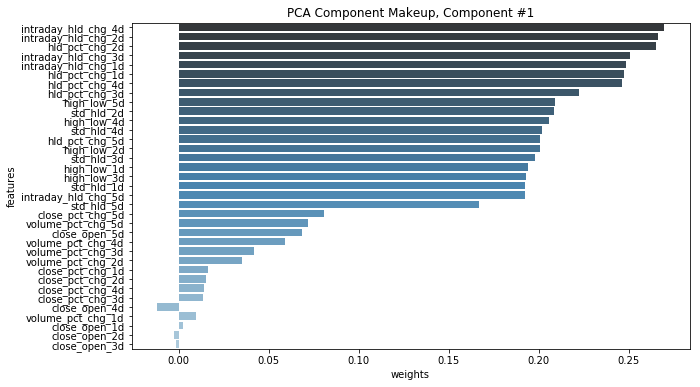

In [61]:
features_list = merged_clean.columns.to_list()
features_list = features_list[:-1]
show_comp(1, features_list)

## sklearn

In [62]:
def evaluation_metrics(test_labels, test_preds):

    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()

    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2*tp / (2*tp + fp + fn)

    return (tp, fp, tn, fn, recall, precision, f1)

In [63]:
%%time

from sklearn.linear_model import LogisticRegression

benchmark_classifier = LogisticRegression(C=1e-2, solver='lbfgs', multi_class='multinomial')

benchmark_classifier.fit(pca_train_features, train_labels_original)

scaler = StandardScaler()
test_features = scaler.fit_transform(test_features)
pca_test_features = pca.transform(test_features)
test_preds = benchmark_classifier.predict(pca_test_features)

test_preds_new = np.zeros((test_preds.shape[0], test_labels.shape[1]))
for i in range(test_preds.shape[0]):
    test_preds_new[i,int(test_preds[i])] = 1
    
(tp, fp, tn, fn, recall, precision, f1) = evaluation_metrics(test_labels, test_preds_new)
print("Benchmark model logistic regression: \n\
      recall: {:.2f}%, precision: {:.2f}%, f1: {:.2f}% \n\
      tp: {}, fp: {}, tn: {}, fn: {}".format(100*recall, 100*precision, 100*f1, tp, fp, tn, fn))



Benchmark model logistic regression: 
      recall: 65.17%, precision: 65.17%, f1: 65.17% 
      tp: 898, fp: 480, tn: 2276, fn: 480
CPU times: user 204 ms, sys: 3.03 ms, total: 207 ms
Wall time: 60.8 ms


In [64]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

names = ["KNN", "Decision Tree", "Neural Net"]

classifiers = [
    KNeighborsClassifier(3), #inherently multiclass
    DecisionTreeClassifier(max_depth=5), #inherently multiclass
    MLPClassifier(alpha=1, max_iter=1000)] #inherently multiclass

for name, clf in zip(names, classifiers):
    clf.fit(pca_train_features, train_labels)
    
    scaler = StandardScaler()
    test_features = scaler.fit_transform(test_features)
    pca_test_features = pca.transform(test_features)
    test_preds = clf.predict(pca_test_features)
    
    (tp, fp, tn, fn, recall, precision, f1) = evaluation_metrics(test_labels, test_preds)
    print("micro evaluation: {} \n\
      recall: {:.2f}%, precision: {:.2f}%, f1: {:.2f}% \n\
      tp: {}, fp: {}, tn: {}, fn: {}".format(name, 100*recall, 100*precision, 100*f1, tp, fp, tn, fn))
    


micro evaluation: KNN 
      recall: 59.80%, precision: 60.32%, f1: 60.06% 
      tp: 824, fp: 542, tn: 2214, fn: 554
micro evaluation: Decision Tree 
      recall: 65.09%, precision: 65.14%, f1: 65.12% 
      tp: 897, fp: 480, tn: 2276, fn: 481
micro evaluation: Neural Net 
      recall: 68.72%, precision: 69.38%, f1: 69.05% 
      tp: 947, fp: 418, tn: 2338, fn: 431
CPU times: user 24.5 s, sys: 844 ms, total: 25.3 s
Wall time: 6.7 s


## keras LSTM

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [66]:
pca_train_features = pca_train_features.reshape((pca_train_features.shape[0], 1, pca_train_features.shape[1]))
pca_test_features = pca_test_features.reshape((pca_test_features.shape[0], 1, pca_test_features.shape[1]))
print(pca_train_features.shape, train_labels.shape, pca_test_features.shape, test_labels.shape)


(5459, 1, 20) (5459, 3) (1378, 1, 20) (1378, 3)


In [111]:
%%time

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(pca_train_features.shape[1], pca_train_features.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(pca_train_features, train_labels, epochs=50, batch_size=260, validation_data=(pca_test_features, test_labels), verbose=2, shuffle=False)


Train on 5459 samples, validate on 1378 samples
Epoch 1/50
 - 5s - loss: 1.0761 - acc: 0.4404 - val_loss: 1.0353 - val_acc: 0.5653
Epoch 2/50
 - 0s - loss: 1.0050 - acc: 0.5834 - val_loss: 0.9642 - val_acc: 0.6517
Epoch 3/50
 - 0s - loss: 0.9404 - acc: 0.6382 - val_loss: 0.8962 - val_acc: 0.6553
Epoch 4/50
 - 0s - loss: 0.8738 - acc: 0.6650 - val_loss: 0.8326 - val_acc: 0.6546
Epoch 5/50
 - 0s - loss: 0.8135 - acc: 0.6714 - val_loss: 0.7797 - val_acc: 0.6459
Epoch 6/50
 - 0s - loss: 0.7629 - acc: 0.6719 - val_loss: 0.7400 - val_acc: 0.6451
Epoch 7/50
 - 0s - loss: 0.7262 - acc: 0.6686 - val_loss: 0.7114 - val_acc: 0.6480
Epoch 8/50
 - 0s - loss: 0.6972 - acc: 0.6778 - val_loss: 0.6904 - val_acc: 0.6524
Epoch 9/50
 - 0s - loss: 0.6754 - acc: 0.6807 - val_loss: 0.6750 - val_acc: 0.6553
Epoch 10/50
 - 0s - loss: 0.6630 - acc: 0.6816 - val_loss: 0.6642 - val_acc: 0.6553
Epoch 11/50
 - 0s - loss: 0.6529 - acc: 0.6846 - val_loss: 0.6549 - val_acc: 0.6626
Epoch 12/50
 - 0s - loss: 0.6432 - ac

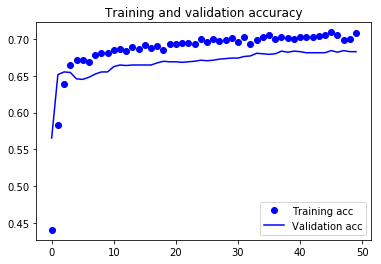

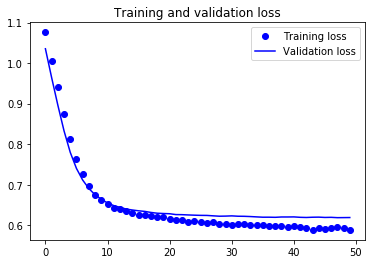

In [112]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(acc, 'bo', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(loss, 'bo', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
# make a prediction

test_preds = model.predict(pca_test_features)
test_labels = test_labels.reshape(test_labels.shape[0],3)

test_preds_new = np.zeros((test_preds.shape[0], test_preds.shape[1]))
for i in range(test_preds.shape[0]):
      highest_prob = np.argmax(test_preds[i,:])
      test_preds_new[i,highest_prob] = 1


In [114]:
(tp, fp, tn, fn, recall, precision, f1) = evaluation_metrics(test_labels, test_preds_new)
print("LSTM \n\
      recall: {:.2f}%, precision: {:.2f}%, f1: {:.2f}% \n\
      tp: {}, fp: {}, tn: {}, fn: {}".format(100*recall, 100*precision, 100*f1, tp, fp, tn, fn))

LSTM 
      recall: 68.29%, precision: 68.29%, f1: 68.29% 
      tp: 941, fp: 437, tn: 2319, fn: 437
